# NETFLIX RECOMMENDATION SYSTEM

The project emphasises on buliding a movie recommendation system for Netflix users. The method used here is Collobarative filtering. 

### Importing the necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict
from collections import deque


### Loading the data

In [2]:
movie_titles = pd.read_csv('movie_titles.csv', 
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['Id', 'Year', 'Name']).set_index('Id')

movie_titles.head(10)

,Year,Name
Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


In [3]:
print(movie_titles.shape)

(17770, 2)


In [4]:
# Load a movie metadata dataset
movie_metadata = pd.read_csv('movies_metadata.csv', low_memory=False)[['original_title', 'overview', 'vote_count']].set_index('original_title').dropna()
# Remove the long tail of rarly rated moves
movie_metadata = movie_metadata[movie_metadata['vote_count']>10].drop('vote_count', axis=1)

print('Shape of Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.head(10)

Shape of Movie-Metadata:	(21604, 1)


,overview
original_title,
Toy Story,"Led by Woody, Andy's toys live happily in his ..."
Jumanji,When siblings Judy and Peter discover an encha...
Grumpier Old Men,A family wedding reignites the ancient feud be...
Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
Father of the Bride Part II,Just when George Banks has recovered from his ...
Heat,"Obsessive master thief, Neil McCauley leads a ..."
Sabrina,An ugly duckling having undergone a remarkable...
Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses..."
Sudden Death,International action superstar Jean Claude Van...


### Data preparation

Combining the data frames to get the final data for building the model

In [5]:
# Load single data-file
df_raw = pd.read_csv('combined_data_1.txt', header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])


# Find empty rows to slice dataframe for each movie
tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)


# Gather all dataframes
user_data = []

# Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()
        
    # Create movie_id column
    tmp_df['Movie'] = movie_id
    
    # Append dataframe to list
    user_data.append(tmp_df)

# Combine all dataframes
rating = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(rating.shape))
rating.head(10)

Shape User-Ratings:	(24053764, 4)


,User,Rating,Date,Movie
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1
6,893988,3.0,2005-11-17,1
7,124105,4.0,2004-08-05,1
8,1248029,3.0,2004-04-22,1
9,1842128,4.0,2004-05-09,1
10,2238063,3.0,2005-05-11,1


In [6]:
rating.shape

(24053764, 4)

Using only 300000 rows

In [7]:
rating = rating[0:300000]

In [8]:
ratings = rating[['User','Movie','Rating']]

In [9]:
ratings.columns = ['userId','movieId','rating']

In [10]:
ratings

,userId,movieId,rating
1,1488844,1,3.0
2,822109,1,5.0
3,885013,1,4.0
4,30878,1,4.0
5,823519,1,3.0
...,...,...,...
300072,1298406,77,3.0
300073,972399,77,2.0
300074,2224485,77,1.0
300075,1556164,77,5.0


In [11]:
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.shape

(300000, 3)

In scikit-surprise, the method to read the data frame is different because it itself basically it creates the user interaction matrix for us and for it to do that, we need to read the data frame in a particular manner.
The Reader object is created with the Reader package from scikit-surprise.

In [12]:
reader = Reader(line_format='user item rating timestamp', sep='\t')
reader = Reader(rating_scale=(0.5, 5.0)) #range of the ratings
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [13]:
data

The surprise dataset is now created. We cannot see into it but a (300000 users) x (total no. of movies) matrix is created in it.

In [14]:
ratings.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userId,rating
127914,305344,75
134221,387418,74
108920,2439493,73
50296,1664010,68
84704,2118461,58
34938,1461435,42
80010,2056022,41
70654,1932594,39
48541,1639792,36
23896,1314869,36


The minimumn number of ratings given by a user is 20, where as the most productive user is user-414 giving 2698 rating. The data is properly distributed and the big chunk of ratings is between 3 and 5 which means people are not very hard towards rating

### Model Selection

There are various models which can be used, like - SVD, MNF, KNN etc.
Let us apply SVD (Singular Value Decomposition) here.

SVD is used as a collaborative filtering technique. It uses a matrix structure where each row represents a user, and each column represents an item. The elements of this matrix are the ratings that are given to items by users.

In [15]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(n_epochs = 1, n_factors = 20),]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

In [16]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.012682,0.675372,1.225403


### Parameter Tuning using Grid search

In [17]:
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#Assigning values
t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

0.9920812977713837
{'n_factors': 25, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.1}


### Training and Testing

In [18]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.9903


0.9902583965758683

In [19]:
predictions

[Prediction(uid='1773296', iid=30, r_ui=4.0, est=3.767668819578092, details={'was_impossible': False}),
 Prediction(uid='355330', iid=30, r_ui=4.0, est=3.767668819578092, details={'was_impossible': False}),
 Prediction(uid='2156074', iid=35, r_ui=3.0, est=2.9771242061093526, details={'was_impossible': False}),
 Prediction(uid='1827263', iid=18, r_ui=4.0, est=3.638424272340207, details={'was_impossible': False}),
 Prediction(uid='2134589', iid=30, r_ui=4.0, est=3.767668819578092, details={'was_impossible': False}),
 Prediction(uid='1861800', iid=52, r_ui=3.0, est=3.973258222831924, details={'was_impossible': False}),
 Prediction(uid='759290', iid=52, r_ui=5.0, est=3.957272288645415, details={'was_impossible': False}),
 Prediction(uid='1519647', iid=30, r_ui=4.0, est=3.806778055250206, details={'was_impossible': False}),
 Prediction(uid='568153', iid=58, r_ui=4.0, est=3.486520962026452, details={'was_impossible': False}),
 Prediction(uid='420482', iid=77, r_ui=4.0, est=2.772567062950244,

'was impossible' indicates that the user who rated that movie had also rated some other movie. If the value was 'True' , then it is like a cold-start problem where we have a completely new user.

Let's check how good or bad our predictions are:
The following function will create a pandas data frame which will consist of these columns:

UID: user-id

iid: Movieid

Rui: the rating given by the user

est: rating estimated by the model

Iu: No of items rated by the user

UI: number of users that have rated this item

err: abs difference between predicted rating and the actual rating.

In [20]:
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)]) 
    except ValueError:return 0 # user was not part of the trainset return 0

In [21]:
def get_Ui(iid):
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:return 0

In [22]:
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details']) 
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu) 
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

In [23]:
df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,1773296,30,4.0,3.767669,{'was_impossible': False},0,88616,0.232331
1,355330,30,4.0,3.767669,{'was_impossible': False},0,88616,0.232331
2,2156074,35,3.0,2.977124,{'was_impossible': False},5,638,0.022876
3,1827263,18,4.0,3.638424,{'was_impossible': False},1,7982,0.361576
4,2134589,30,4.0,3.767669,{'was_impossible': False},0,88616,0.232331


#### top 10 best and worst predictions made by the model

In [24]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [25]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
71442,1664010,32,5.0,5.0,{'was_impossible': False},52,1403,0.0
45646,722591,25,5.0,5.0,{'was_impossible': False},12,895,0.0
55831,1745577,5,5.0,5.0,{'was_impossible': False},6,836,0.0
30084,642384,30,5.0,5.0,{'was_impossible': False},10,88616,0.0
3923,722591,76,5.0,5.0,{'was_impossible': False},12,2171,0.0
43622,1745577,68,5.0,5.0,{'was_impossible': False},6,1691,0.0
33893,794999,44,5.0,5.0,{'was_impossible': False},13,6361,0.0
8722,794999,71,5.0,5.0,{'was_impossible': False},13,1168,0.0
27384,165247,68,5.0,5.0,{'was_impossible': False},8,1691,0.0
41007,1664010,33,5.0,5.0,{'was_impossible': False},52,5186,0.0


In [26]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
55986,1764804,76,1.0,4.535731,{'was_impossible': False},2,2171,3.535731
16449,2069625,33,1.0,4.548283,{'was_impossible': False},3,5186,3.548283
62277,2133551,33,1.0,4.597651,{'was_impossible': False},4,5186,3.597651
12980,680052,46,1.0,4.599908,{'was_impossible': False},3,4943,3.599908
39823,1161725,76,1.0,4.610925,{'was_impossible': False},3,2171,3.610925
13958,8388,33,1.0,4.616890,{'was_impossible': False},3,5186,3.616890
36761,735623,18,1.0,4.630138,{'was_impossible': False},4,7982,3.630138
2445,126592,68,1.0,4.648686,{'was_impossible': False},2,1691,3.648686
39781,2457095,77,5.0,1.341814,{'was_impossible': False},17,7317,3.658186
57565,237672,33,1.0,4.750999,{'was_impossible': False},4,5186,3.750999


As we can see above, the worst predictions are made for ratings with 1.0. This occurs as most of our data as the ratings between 3.0 to 5.0 and very few with such low ratings. Hence a higher rating is predicted by the model.

In [27]:
ratings[0:10]

,userId,movieId,rating
1,1488844,1,3.0
2,822109,1,5.0
3,885013,1,4.0
4,30878,1,4.0
5,823519,1,3.0
6,893988,1,3.0
7,124105,1,4.0
8,1248029,1,3.0
9,1842128,1,4.0
10,2238063,1,3.0


Lets see the stats of movie ID 33

In [28]:
ratings.loc[ratings['movieId'] == 33]['rating'].describe()

count    6890.000000
mean        4.168650
std         1.152857
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

So here we observe that the mean is as high as 4.16 and 75% of the data has 5 rating. Hence itis difficult for the model to predict a rating as low as 1.0

##### In recommendation systems, we are interested in showing the top N items to users and so the best is to compute precision and recall on top N values instead of calculating on all the items.

#### Definition of Relevant and Recommended

Relevant: True Rating > = 2.5

Irrelevant: True Rating < 2.5

Recommended item: Predicted Rating > = 3.5

Not Recommended item: Predicted Rating > = 3.5

#### Calculating Precision, Recall and F1 score

In [29]:

#Calculate TP,FP,TN,FN at every threshold level (0.0 - 5.0)

final = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1   

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,75000,0,0,0,1.000000,1.000000,1.000000
1,0.5,75000,0,0,0,1.000000,1.000000,1.000000
2,1.0,74979,0,0,21,1.000000,0.999720,0.999860
3,1.5,71502,3425,57,16,0.954289,0.999776,0.976503
4,2.0,71436,3339,143,82,0.955346,0.998853,0.976615
5,2.5,64240,9588,771,401,0.870131,0.993797,0.927861
6,3.0,60303,7322,3037,4338,0.891726,0.932891,0.911844
7,3.5,37304,19299,12158,6239,0.659046,0.856716,0.744992
8,4.0,5614,1585,29872,37929,0.779831,0.128930,0.221276
9,4.5,155,66,58257,16522,0.701357,0.009294,0.018345


As per the results above, the optimal value for threshold is 2.5.

The next step is to find the optimal K value, and to find it we have to first calculate precision and recall for all the K values(2-10) having threshold value 2.5.

Below is the function to calculate precision and recall at K.

In [30]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls
    
    
###


In [31]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results

[{'K': 2, 'Precision': 0.8760123135211935, 'Recall': 0.9875659695633641},
 {'K': 3, 'Precision': 0.8753861130844318, 'Recall': 0.9939516327990162},
 {'K': 4, 'Precision': 0.8752427184466018, 'Recall': 0.995023801152146},
 {'K': 5, 'Precision': 0.8751969374062669, 'Recall': 0.9952207479551785},
 {'K': 6, 'Precision': 0.8751974636251214, 'Recall': 0.9953083608316855},
 {'K': 7, 'Precision': 0.8751940807896287, 'Recall': 0.9953245514582243},
 {'K': 8, 'Precision': 0.87519267127484, 'Recall': 0.9953316528500047},
 {'K': 9, 'Precision': 0.8751928905326961, 'Recall': 0.9953367809210811},
 {'K': 10, 'Precision': 0.8751932413452658, 'Recall': 0.9953419089921576}]

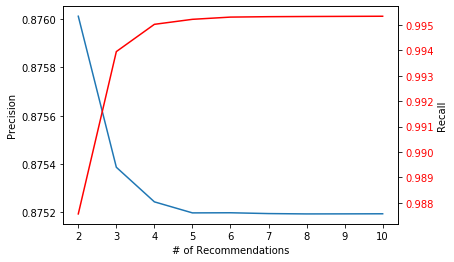

In [32]:
Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')

As the graph states, Precision drops significantly when K=3
So we will consider the value of K to be 3.

#### Recommending movies to the user

Now as we know the optimal number of recommendations to provie, it's time to give recommendations to users. To do so we have to predict ratings for the movies which user has not yet watched.

Here we will be using build_anti_testset() method to get the data for testset as we have to predict ratings for the (user, item) pairs which are not present.

In [ ]:
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

The algorithm will be run on the entire data set. Previously it was done on splitted train and test set so that we obtain the best hyperparameters.

Below is the function to get all the prediction sorted.

In [34]:
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n


In [35]:
all_pred = get_all_predictions(predictions)


In [36]:
all_pred


defaultdict(list,
            {'1488844': [(13, 4.169515649389644),
              (33, 4.026710519056484),
              (68, 4.016413923628109),
              (37, 3.7974876548379193),
              (73, 3.74883300988709),
              (25, 3.730138956462569),
              (71, 3.6963311538797434),
              (32, 3.6723333005167436),
              (5, 3.627218471228415),
              (52, 3.6261887171620444),
              (28, 3.6147170613466897),
              (48, 3.5973420933575997),
              (49, 3.5862796724212886),
              (46, 3.537277237424915),
              (3, 3.5141064672702726),
              (2, 3.5032336229305745),
              (57, 3.502918816824983),
              (62, 3.4702441283654384),
              (56, 3.4661167086759628),
              (18, 3.4515153863167503),
              (51, 3.4302297292292976),
              (29, 3.4262276800553977),
              (27, 3.3912481340873484),
              (21, 3.3903552500564214),
              (23, 3.37


As we have all the predicted rating, We'll subset to only top K movies for every user, where K is 4

In [37]:

#To get top 4 reommendation
n = 3

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]


In [38]:
all_pred

defaultdict(list,
            {'1488844': [(13, 4.169515649389644),
              (33, 4.026710519056484),
              (68, 4.016413923628109)],
             '822109': [(13, 4.615089955602989),
              (33, 4.504869574680645),
              (68, 4.4381677971187425)],
             '885013': [(13, 4.6288187989386484),
              (33, 4.472323506915722),
              (68, 4.403889343297888)],
             '30878': [(13, 4.078014920226622),
              (33, 3.98629592805572),
              (68, 3.914229684125754)],
             '823519': [(13, 4.383418709711461),
              (33, 4.224885389969042),
              (68, 4.167142512391837)],
             '893988': [(13, 4.365868366780284),
              (68, 4.278310385391941),
              (33, 4.2542541675460335)],
             '124105': [(13, 4.483653188900171),
              (68, 4.350605890191888),
              (33, 4.317786511407632)],
             '1248029': [(13, 3.8519686125370955),
              (33, 3.722545785241

Let us see what movies will be recommended for the user 2549926

In [39]:
all_pred['2549926']

[(13, 4.753117135096211), (33, 4.665839801810622), (68, 4.541010407846324)]

So the movies with movie IDs 13, 33 and 68 are recommended.

#### That's the end of the project. I would like to thank Utsav Aggarwal for explaining the project.
https://www.youtube.com/watch?v=lw-jhNLFscI